In [91]:
from typing import Optional, Callable, Union
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

class ErdosRenyiNetwork:
    def __init__(self, loop:bool=False, directed:bool=False):
        """
        ...
        """
        self.__loop     = loop
        self.__directed = directed
    
    def __call__(self, n:int, Mp:Union[int,float], wFunc:Union[Callable,int,float]=1, args:dict=None, seed:Optional[int]=None):
        if isinstance(Mp,float):
            assert 0 <= Mp <= 1, 'Probability must be between [0,1]'            
            np.random.seed(seed)
            p    = Mp
            mask = p < np.random.rand(n,n)
    
        elif isinstance(Mp,int):
            table    = {(True ,True ):('n^2'   ,n*n    ), (True ,False):('n(n+1)/2',n*(n+1)/2),
                        (False,True ):('n(n-1)',n*(n-1)), (False,False):('n(n-1)/2',n*(n-1)/2)}            
            msg, lim = table[(self.__loop, self.__directed)]
            
            assert 0 <= Mp < lim, f'Number of edges must be between (0, {lim}), {msg}'            
            np.random.seed(seed)            
            M = Mp
            
            adj   = np.zeros((n,n))
            table = {(True ,True ): np.where(adj == 0)      , (True ,False): np.triu_indices(n,k=0),
                     (False,True ): np.where(np.eye(n) != 0), (False,False): np.triu_indices(n,k=1)}
            
            rows, cols  = table[(self.__loop, self.__directed)]
            choices     = np.random.choice(len(rows), size=M, replace=False)
            sample      = (rows[choices], cols[choices])                
            adj[sample] = 1                
            mask = adj != 1
        
        else: raise TypeError('Argument Mp must be either integer or float type')
        
        if isinstance(wFunc,(float,int)): wArr = np.full((n,n),wFunc)
        else                            : wArr = wFunc(size=(n,n),**args)
        
        adj   = np.where(mask,0,wArr)
        
        if not self.__loop    : np.fill_diagonal(adj, 0)
        if not self.__directed: adj = np.triu(adj) + np.triu(adj,1).T
        return adj 
        
class BarabasiAlbertNetwork:
    def __init__(self, directed:bool=False, loop:bool=False):
        """
        ...
        """
        self.__directed = directed
        self.__loop     = loop
    
    def __call__(self, n:int, p:float, w:Union[Callable,int,float]=1, args:dict=None, seed:Optional[int]=None):
        assert 0 <= p <= 1, 'Probability must be between [0,1]'
        
        np.random.seed(seed)
        
        if isinstance(w,(float,int)): adj = np.full((n,n),w)
        else                        : adj = w(size=(n,n),**args)
        
        mask  = p < np.random.rand(n,n)
        adj   = np.where(mask,0,adj)
        
        if not self.__loop    : np.fill_diagonal(adj, 0)
        if not self.__directed: adj = np.triu(adj) + np.triu(adj,1).T
        return adj

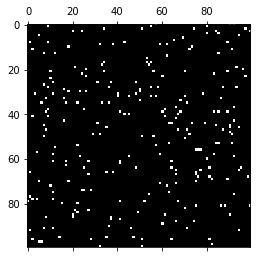

250

In [94]:
ER   = ErdosRenyiNetwork(True,True)
plt.matshow(ER(100,250),cmap='bone')
plt.show()
ER(100,250).sum()

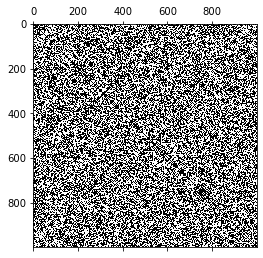

In [2]:
ER   = ErdosRenyiNetwork()
#args = dict(low=0, high=1)

adj = ER(1000,.5)

plt.matshow(adj,cmap='bone')
plt.show()

In [72]:
adj.sum() / np.prod(adj.shape)

0.498832

In [10]:
np.random.uniform(**args, size=(6,6))

array([[0.54353059, 0.55075134, 0.5759225 , 0.79109307, 0.69050174,
        0.16827618],
       [0.24927391, 0.33811785, 0.68689313, 0.15740277, 0.42172533,
        0.27139106],
       [0.72830238, 0.49783239, 0.90303849, 0.46404694, 0.79360704,
        0.09484752],
       [0.89997115, 0.80232717, 0.14211265, 0.78488521, 0.98231652,
        0.43776317],
       [0.11077055, 0.49657165, 0.3688321 , 0.53205518, 0.32834794,
        0.03234872],
       [0.56317263, 0.7439186 , 0.09515904, 0.01026556, 0.66076683,
        0.40245009]])

In [41]:


def ErdosRenyiModel(N:int,p:float,directed:bool=False):
    """
    For undirected graphs w/o self loops
    from itertools import combinations as C
    print(*[f'{ni}<->{nj}' for (ni,nj) in C(['n1', 'n2', 'n3'], 2)], sep=', ')
    >>> n1<->n2, n1<->n3, n2->n3
    
    ---------------------------------------    
    For undirected graphs w/ self loops
    from itertools import combinations_with_replacement as Cwr
    print(*[f'{ni}<->{nj}' for (ni,nj) in Cwr(['n1', 'n2', 'n3'], 2)], sep=', ')
    >>> n1<->n1, n1<->n2, n1<->n3, n2<->n2, n2<->n3, n3<->n3
    
    ---------------------------------------
    For directed graphs w/o self loops
    from itertools import permutations as P
    print(*[f'{ni}->{nj}' for (ni,nj) in P(['n1', 'n2', 'n3'], 2)], sep=', ')
    >>> n1->n2, n1->n3, n2->n1, n2->n3, n3->n1, n3->n2
    
    ---------------------------------------
    For directed graphs w/ self loops
    from itertools import product as Pr
    print(*[f'{ni}->{nj}' for (ni,nj) in Pr(['n1', 'n2', 'n3'], repeat=2)], sep=', ')
    >>> n1->n1, n1->n2, n1->n3, n2->n1, n2->n2, n2->n3, n3->n1, n3->n2, n3->n3
    """
    
    adj = np.zeros((N,N),dtype=np.uint8)
    num = range(N)
    
    if directed:
        from itertools import permutations as P
        for ni, nj in P(num,2):
            if random.random() < p: adj[ni,nj] = 1
    else:
        from itertools import combinations as C
        for ni, nj in C(num,2):
            if random.random() < p: adj[ni,nj] = adj[nj,ni] = 1
    
    return adj

def Adj2Graph(adj:np.array):
    nrow, ncol = adj.shape
    rows, cols = np.where(adj != 0)

    nodes = [f'n{num}' for num in range(nrow)]
    edges = [(nodes[i], nodes[j]) for (i, j) in zip(rows, cols)]

    adj = nx.Graph()
    adj.add_nodes_from(nodes)
    adj.add_edges_from(edges)
    return adj

def plot(G:Union[np.array,nx.Graph]):
    if isinstance(G,np.ndarray): G = Adj2Graph(G)
        
    degs = [d for (n, d) in sorted(G.degree(), key=lambda arg:-arg[1])]    
    fig  = plt.figure("Degree of a random graph", figsize=(8, 8))
    grid = fig.add_gridspec(3, 3)
    
    ax0  = fig.add_subplot(grid[0:2,:])    
    pos  = nx.spring_layout(G)
    nopt = {"node_color":"red","node_size":30}
    eopt = {"edge_color":"black","width": 0.75,"alpha":0.85}
    nx.draw_networkx_nodes(G, pos, ax=ax0, **nopt)
    nx.draw_networkx_edges(G, pos, ax=ax0, **eopt)
    ax0.set_title("Connected components of G")
    ax0.set_axis_off()
    
    ax1  = fig.add_subplot(grid[2:3,0])
    ax1.plot(degs, "b-.", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    
    ax2  = fig.add_subplot(grid[2:3,1])
    ax2.matshow(adj,cmap="bone")
    ax2.set_title("Adjacency Matrix")
    ax2.set_axis_off()   
    
    ax3  = fig.add_subplot(grid[2:3,2])
    ax3.bar(*np.unique(degs, return_counts=True))
    ax3.set_title("Degree histogram")
    ax3.set_xlabel("Degree")
    ax3.set_ylabel("# of Nodes") 

    fig.tight_layout()
    plt.show()

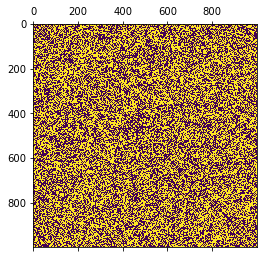

In [44]:
plt.matshow(ErdosRenyiModel(1000,0.5))
plt.show()

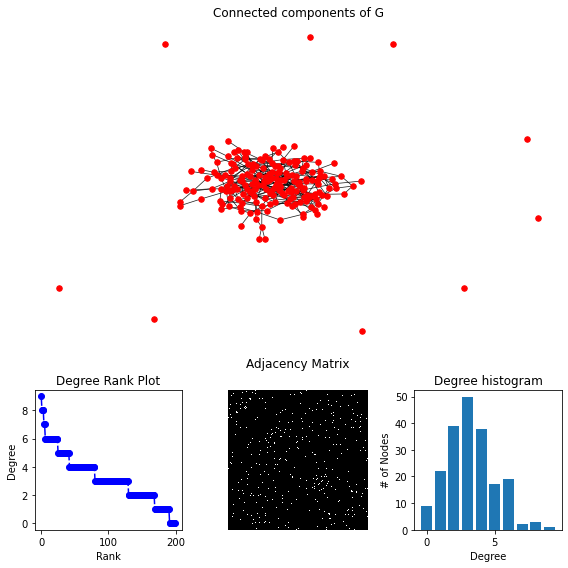

In [42]:
adj = ErdosRenyiModel(200,0.015)
plot(adj)

In [21]:
G = Adj2Graph(adj)

In [27]:
(hub, degree), *_ = sorted(G.degree(), key=lambda arg:-arg[1])

In [28]:
degree

8

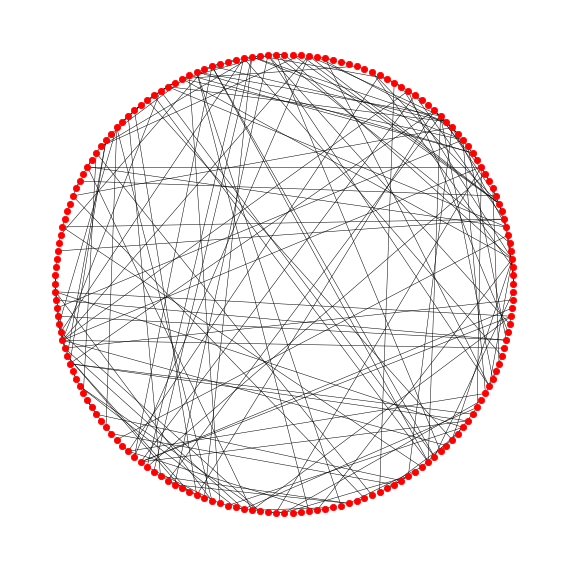

In [65]:
G1  = ErdosRenyiModel(200,0.01)
G2  = nx.generators.random_graphs.erdos_renyi_graph(200,0.01)

plot(G1)

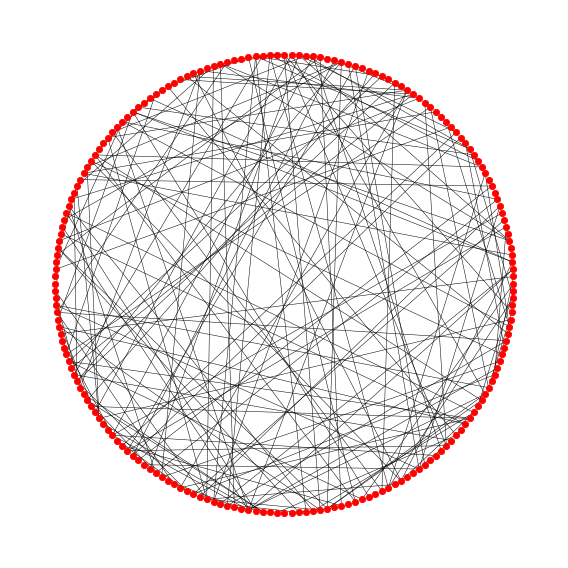

In [66]:
plot(G2)

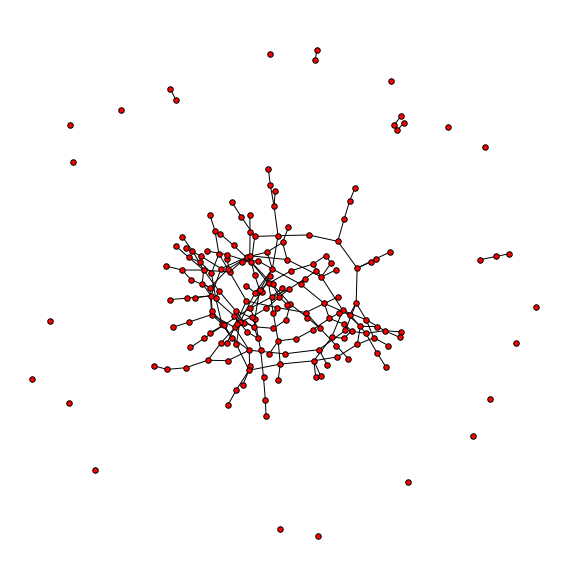

In [35]:
plot(G2)